# CAP 6619 - Deep Learning
## Project 5
## Sequential data (timeseries + text)

## Introduction: Worksheet Structure and Design

This Worksheet is separated into five parts:

Part 1: the first has to do with the analysis and ML capabilities around time series data, 

Part 2: Has to do with a specific NLP problem, the sentimental analysis (really binary classification) of the IMDB (movie) review data using a variety of ML and Neural Network techniques.  Part 2A and 2B use LSTM (Long Short Term Networks) layers and then Part 2C explores two different Transfer Learning techniques, the first (Part 2C.1) uses GloVe embeddings and then (Part 2C.2) uses Transfer Learning with BERT, or Bidirectional Encoder Representation from Transformers.

Part 3: Is an example of using Transformers to solve a typical NLP problem around langugae translation

Appendix A: More on BERT architectures, both in terms of description as well as another example is provided not related to the IMDB data set (uses CoLA data set)

Appendix B: Overview of Text Summarization, techniques and samples.

The TODOs for the assignment are in Parts 1 and 2, while the rest of the worksheet essentially captures the study and analysis into deeper NLP problems, architectures and techniques.

NB: Sources are sprinkled throghout but are primarily section dependent. All code is referenced and the worksheet is run end to end before submission and finalization. Some of the sections take a long time to run given the comlexity and resource requirements of the underlying (NLP) code.



## Part 1: Temperature forecasting using RNNs

Following closely along Chapter 10 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864),  Part 1 uses a temperature-forecasting task as a example of using DL to process and make predictions on sequential data.

Dataset: recorded at [the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany](https://www.bgc-jena.mpg.de/wetter/), it consists of 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on)  recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.

Useful sources and references for Part 1:

https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter10_dl-for-timeseries.ipynb 


### What is Recurrent neural network(RNN)?

(Kosandal 2019)

*RNN is a deep learning model that is used for Time-series prediction, speech recognition, etc. Unlike traditional neural networks, recurrent networks use their memory(also called states) to predict sequence outputs. In simple words, RNN is used when we want to predict a future outcome based on the previous sequential inputs. For example, we can use RNN to predict the next word in a sentence by providing previous words.*



### Acquiring and inspecting the data

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-07-22 14:34:07--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.130.37
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.130.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  13.5MB/s    in 1.0s    

2022-07-22 14:34:09 (13.5 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data**

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

*Over 8 years, yearly fluctuations can be seen clearly*

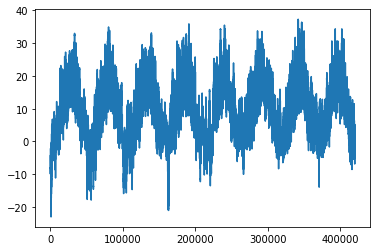

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

*because data is recorded every 10 min, we get 144 data points per day (24x6)*

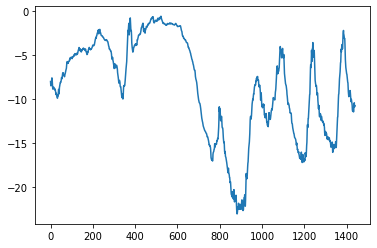

In [5]:
plt.plot(range(1440), temperature[:1440])

Can see daily fluctuations, also that clearly the data is from a cold month

**Computing the number of samples we'll use for each data split**

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [7]:
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
#
# sample timeseries data from array
#
import numpy as np
from tensorflow import keras

int_sequence = np.arange(10)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [12]:
for samples, targets in val_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [13]:
for samples, targets in test_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### Building a baseline "model"

In this case we will try to predict the temperature by simply assuming that the temperature 24 hours from now will be equal to the temperature right now. 

We shall use the mean absolute error (MAE) as a metric of performance and consider this (rather silly) "model" as our baseline. 


**Computing the common-sense baseline MAE**

In [14]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

In [15]:
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Single layer LSTM

This is essentially the "simple LSTM-based model" from Listing 10.12 in the textbook.

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [17]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 35s 34ms/step - loss: 38.2405 - mae: 4.5021 - val_loss: 12.5286 - val_mae: 2.6777
Epoch 2/10
819/819 [==============================] - 27s 33ms/step - loss: 10.8826 - mae: 2.5648 - val_loss: 9.5618 - val_mae: 2.4024
Epoch 3/10
819/819 [==============================] - 27s 33ms/step - loss: 9.7767 - mae: 2.4359 - val_loss: 9.3428 - val_mae: 2.3806
Epoch 4/10
819/819 [==============================] - 27s 33ms/step - loss: 9.3035 - mae: 2.3717 - val_loss: 9.3471 - val_mae: 2.3804
Epoch 5/10
819/819 [==============================] - 27s 33ms/step - loss: 9.0092 - mae: 2.3318 - val_loss: 9.6672 - val_mae: 2.4247
Epoch 6/10
819/819 [==============================] - 28s 34ms/step - loss: 8.8169 - mae: 2.3035 - val_loss: 9.8103 - val_mae: 2.4453
Epoch 7/10
819/819 [==============================] - 27s 33ms/step - loss: 8.6629 - mae: 2.2842 - val_loss: 9.9450 - val_mae: 2.4669
Epoch 8/10
819/819 [==============================] - 27s 3

In [18]:
model = keras.models.load_model("jena_lstm.keras")

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 9s 20ms/step - loss: 11.1486 - mae: 2.6369
Test MAE: 2.64


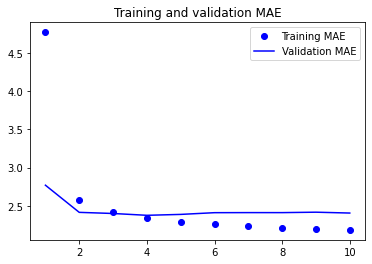

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

###TODO 1a: Double Layer GRU Model w/Dropout

Following along the Chapter... *Training and evaluating a dropout-regularized, stacked GRU model*

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [20]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 501s 608ms/step - loss: 25.1027 - mae: 3.7026 - val_loss: 9.6772 - val_mae: 2.4188
Epoch 2/10
819/819 [==============================] - 497s 607ms/step - loss: 14.0321 - mae: 2.9042 - val_loss: 8.7594 - val_mae: 2.2933
Epoch 3/10
819/819 [==============================] - 496s 606ms/step - loss: 13.2013 - mae: 2.8142 - val_loss: 8.4263 - val_mae: 2.2473
Epoch 4/10
819/819 [==============================] - 495s 605ms/step - loss: 12.6908 - mae: 2.7626 - val_loss: 8.8065 - val_mae: 2.3115
Epoch 5/10
819/819 [==============================] - 496s 605ms/step - loss: 12.1960 - mae: 2.7090 - val_loss: 8.6240 - val_mae: 2.2750
Epoch 6/10
819/819 [==============================] - 495s 605ms/step - loss: 11.7611 - mae: 2.6626 - val_loss: 9.1504 - val_mae: 2.3575
Epoch 7/10
819/819 [==============================] - 495s 604ms/step - loss: 11.4121 - mae: 2.6206 - val_loss: 9.0048 - val_mae: 2.3389
Epoch 8/10
819/819 [=====================

In [ ]:
model = keras.models.load_model("jena_stacked_gru_dropout.keras")

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 36s 86ms/step - loss: 9.6008 - mae: 2.4200
Test MAE: 2.42


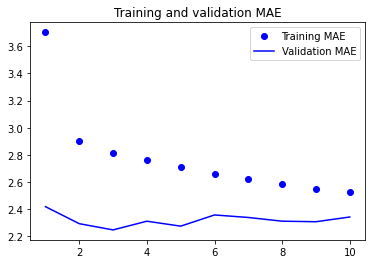

In [21]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Another Example (Kosandal 2019)

Example from *Weather forecasting with Recurrent Neural Networks in Python* by 
Rohan Kosandal Dec 2019 available here: https://medium.com/analytics-vidhya/weather-forecasting-with-recurrent-neural-networks-1eaa057d70c3

#### Load and Transform Data

In [22]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import glob
import os

os.chdir("/content/drive/MyDrive/google_colab/deep_learning/Assignment 5/time series (weather)")

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#import dataset from data.csv file
dataset = pd.read_csv('./training.csv', header=0, sep='\t')

In [25]:
dataset.head

<bound method NDFrame.head of        Date time  Temperature
0     01/01/2011         68.9
1     01/02/2011         66.4
2     01/03/2011         68.7
3     01/04/2011         71.4
4     01/05/2011         69.3
...          ...          ...
3098  06/26/2019         75.7
3099  06/27/2019         75.0
3100  06/28/2019         72.7
3101  06/29/2019         71.0
3102  06/30/2019         70.8

[3103 rows x 2 columns]>

In [26]:
dataset = dataset.dropna(subset=["Temperature"])
dataset=dataset.reset_index(drop=True)

dataset.head

<bound method NDFrame.head of        Date time  Temperature
0     01/01/2011         68.9
1     01/02/2011         66.4
2     01/03/2011         68.7
3     01/04/2011         71.4
4     01/05/2011         69.3
...          ...          ...
3066  06/26/2019         75.7
3067  06/27/2019         75.0
3068  06/28/2019         72.7
3069  06/29/2019         71.0
3070  06/30/2019         70.8

[3071 rows x 2 columns]>

In [27]:
training_set = dataset.iloc[:,1:2].values

Next, we will have to apply feature scaling to normalize temperature in the range 0 to 1.

In [28]:
#Feature Scaling 
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))

training_set_scaled = sc.fit_transform(training_set)

We will create a training set such that for every 30 days we will provide the next 4 days temperature as output. In other words, input for our RNN would be 30 days temperature data and the output would be 4 days forecast of temperature.

In [29]:
x_train = []
y_train = []
n_future = 4 # next 4 days temperature forecast
n_past = 30 # Past 30 days 
for i in range(0,len(training_set_scaled)-n_past-n_future+1):
    x_train.append(training_set_scaled[i : i + n_past , 0])     
    y_train.append(training_set_scaled[i + n_past : i + n_past + n_future , 0 ])
x_train , y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 1) )

In [30]:
x_train.shape, y_train.shape

((3038, 30, 1), (3038, 4))

x_train contains 30 previous temperature inputs before that day and y_train contains 4 days temperature outputs after that day. Since x_train and y_train are lists we will have to convert them to numpy array to fit training set to our model.

Now we are ready with our training data so let’s proceed to build an RNN model for forecasting weather.

First, we will import keras sequential model from keras.models and keras layers ie. LSTM, Dense and dropout. 

#### Build and Train the Model

In [31]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Bidirectional

# Fitting RNN to training set using Keras Callbacks. Read Keras callbacks docs for more info.

regressor = Sequential()
regressor.add(Bidirectional(LSTM(units=30, return_sequences=True, input_shape = (x_train.shape[1],1) ) ))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 30 , return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 30 , return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 30))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = n_future,activation='linear'))

In [32]:
regressor.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc'])

In [33]:
#regressor.fit(x_train, y_train, epochs=500,batch_size=32 )

regressor.fit(x_train, y_train, epochs=50,batch_size=64 )


Epoch 1/50
48/48 [==============================] - 8s 12ms/step - loss: 0.0525 - acc: 0.2525
Epoch 2/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0183 - acc: 0.2515
Epoch 3/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0159 - acc: 0.2465
Epoch 4/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0146 - acc: 0.2597
Epoch 5/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0132 - acc: 0.2535
Epoch 6/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0127 - acc: 0.2617
Epoch 7/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0118 - acc: 0.2656
Epoch 8/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0116 - acc: 0.2538
Epoch 9/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0114 - acc: 0.2456
Epoch 10/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0106 - acc: 0.2564
Epoch 11/50
48/48 [==============================] - 1s 12m

#### Evaluate the Model

In [34]:
# read test dataset
testdataset = pd.read_csv('./testing.csv')

In [35]:
#get only the temperature column
testdataset = testdataset.iloc[:30,1:2].values

In [36]:
real_temperature = pd.read_csv('./testing.csv')
real_temperature = real_temperature.iloc[30:,1:2].values

testing = sc.transform(testdataset)
testing = np.array(testing)
testing = np.reshape(testing,(testing.shape[1],testing.shape[0],1))

In [37]:
predicted_temperature = regressor.predict(testing)
predicted_temperature = sc.inverse_transform(predicted_temperature)
predicted_temperature = np.reshape(predicted_temperature,(predicted_temperature.shape[1],predicted_temperature.shape[0]))

In [38]:
real_temperature

array([[81.],
       [81.]])

In [39]:
predicted_temperature

array([[78.685555],
       [78.459175],
       [78.2711  ],
       [77.983665]], dtype=float32)

### Summary table

| Method | Test MAE | Remarks |
| --- | --- | --- |
| Baseline | 2.62 | Silly model: "tomorrow will be like today" |
| 1a) Real first model (LSTM) | 2.64 | Same result, no signs of overfitting after 10 epochs |
| 1b) Double Layer GRU Model w/Dropout | 2.42 | better result, although takes time to train (GPU not available given params). Appears to still be learning after 10 epochs though |


##Part 2: Sentiment analysis of IMDB Dataset

In Part 2 we will revisit the IMDB movie review classification task from an earlier assignment, this time using more sophisticated approaches and architectures.

Please refer to Chapter 11 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864) for background information on NLP and approaches for text representation in deep learning architectures.

The code (and much of the text) below is essentially from https://www.tensorflow.org/text/tutorials/text_classification_rnn  


Useful sources and references for Part 2:

- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part01_introduction.ipynb
- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part02_sequence-models.ipynb 


###A word on Long short-term memory (LSTM) Networks

from https://en.wikipedia.org/wiki/Long_short-term_memory

Long short-term memory (LSTM)[1] is an artificial neural network used in the fields of artificial intelligence and deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. Such a recurrent neural network can process not only single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition,[2] speech recognition,[3][4] machine translation,[5][6] robot control,[7][8] video games,[9][10] and healthcare.[11] LSTM has become the most cited neural network of the 20th century.[12]

A common LSTM unit is composed of a cell, an input gate, an output gate[13] and a forget gate.[14] The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the vanishing gradient problem[15] that can be encountered when training traditional RNNs. Relative insensitivity to gap length is an advantage of LSTM over RNNs, hidden Markov models and other sequence learning methods in numerous applications.[citation needed]

###2A: Single LSTM Layer

##### Imports + auxiliary function

In [40]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [41]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

##### Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [42]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9JP0EO/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9JP0EO/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9JP0EO/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [43]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [44]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [45]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [46]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'This is one of the best crime-drama movies during the late 1990s. It was filled with a great cast, a powerful storyline, and many of the players involved gave great performances. Pacino was great; he should have been nominated for something. John Cusack was good too, as long as the viewer doesn\'t mind his Louuu-siana accent. He may come off as annoying if you can\'t stand this dialect. The way that Pacino\'s character interacted with Cusack\'s character was believable, dramatic, and slightly comical at times. Danny Aiello was superb as always. David Paymer was great in a supporting role. Bridget Fonda was good but not memorable. There were times when this picture mentioned so many characters, probably too many. It may take a second viewing to remember, "which Zapatti was which?" After so many cross-references, one has to stop and think just to recap. The ending didn\'t have a lot of sting. It was built up for so long and then was a bit of a letdown. This was one of the few 

##### Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [47]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [48]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [49]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,   7,  29, ...,   0,   0,   0],
       [  1, 225,   1, ...,   0,   0,   0],
       [  9,   1,  45, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [50]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'This is one of the best crime-drama movies during the late 1990s. It was filled with a great cast, a powerful storyline, and many of the players involved gave great performances. Pacino was great; he should have been nominated for something. John Cusack was good too, as long as the viewer doesn\'t mind his Louuu-siana accent. He may come off as annoying if you can\'t stand this dialect. The way that Pacino\'s character interacted with Cusack\'s character was believable, dramatic, and slightly comical at times. Danny Aiello was superb as always. David Paymer was great in a supporting role. Bridget Fonda was good but not memorable. There were times when this picture mentioned so many characters, probably too many. It may take a second viewing to remember, "which Zapatti was which?" After so many cross-references, one has to stop and think just to recap. The ending didn\'t have a lot of sting. It was built up for so long and then was a bit of a letdown. This was one of the fe

##### Create the model

Please refer to https://www.tensorflow.org/text/tutorials/text_classification_rnn for detailed explanation + diagram.

In [51]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [52]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [53]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00086083]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [54]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.00086083]


Compile the Keras model to configure the training process:

In [55]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

##### Train the model

In [56]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 38s 79ms/step - loss: 0.6408 - accuracy: 0.5748 - val_loss: 0.5283 - val_accuracy: 0.7203
Epoch 2/10
391/391 [==============================] - 29s 74ms/step - loss: 0.4776 - accuracy: 0.7738 - val_loss: 0.4198 - val_accuracy: 0.8052
Epoch 3/10
391/391 [==============================] - 29s 75ms/step - loss: 0.3780 - accuracy: 0.8303 - val_loss: 0.3727 - val_accuracy: 0.8484
Epoch 4/10
391/391 [==============================] - 29s 74ms/step - loss: 0.3441 - accuracy: 0.8491 - val_loss: 0.3480 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 29s 74ms/step - loss: 0.3278 - accuracy: 0.8569 - val_loss: 0.3456 - val_accuracy: 0.8646
Epoch 6/10
391/391 [==============================] - 30s 75ms/step - loss: 0.3165 - accuracy: 0.8644 - val_loss: 0.3256 - val_accuracy: 0.8531
Epoch 7/10
391/391 [==============================] - 29s 74ms/step - loss: 0.3097 - accuracy: 0.8676 - val_loss: 0.3244 - val_accuracy:

#####Evaluate the Model

In [57]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 16s 41ms/step - loss: 0.3211 - accuracy: 0.8532
Test Loss: 0.3210562765598297
Test Accuracy: 0.85316002368927


(0.0, 0.65782510638237)

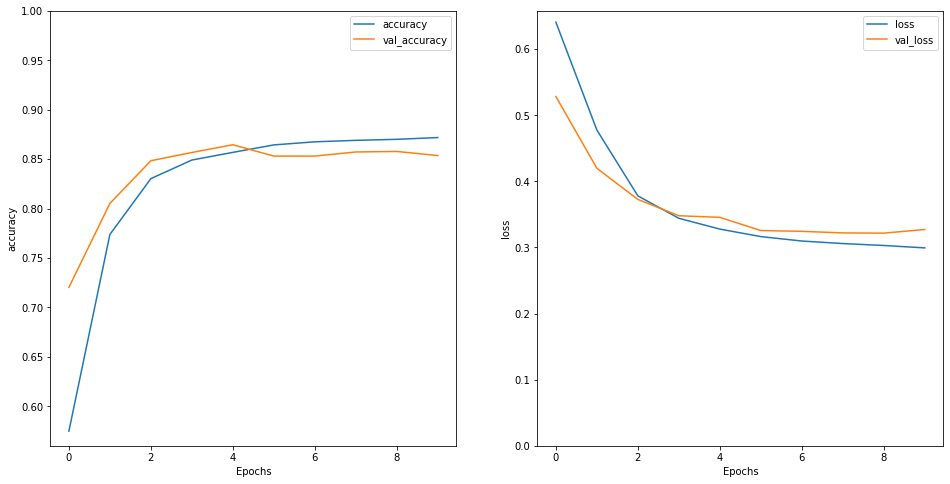

In [58]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [59]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

In [60]:
predictions

array([[0.806023]], dtype=float32)

###2B: Stacking two LSTM layers

Please refer to https://www.tensorflow.org/text/tutorials/text_classification_rnn for additional explanation + diagram.

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

####Create the model

In [61]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [62]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

####Train the model

In [63]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 67s 138ms/step - loss: 0.6258 - accuracy: 0.5814 - val_loss: 0.4343 - val_accuracy: 0.8062
Epoch 2/10
391/391 [==============================] - 50s 126ms/step - loss: 0.3766 - accuracy: 0.8349 - val_loss: 0.3550 - val_accuracy: 0.8339
Epoch 3/10
391/391 [==============================] - 50s 128ms/step - loss: 0.3335 - accuracy: 0.8570 - val_loss: 0.3345 - val_accuracy: 0.8469
Epoch 4/10
391/391 [==============================] - 50s 128ms/step - loss: 0.3175 - accuracy: 0.8647 - val_loss: 0.3306 - val_accuracy: 0.8396
Epoch 5/10
391/391 [==============================] - 50s 126ms/step - loss: 0.3109 - accuracy: 0.8664 - val_loss: 0.3282 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 51s 128ms/step - loss: 0.3050 - accuracy: 0.8712 - val_loss: 0.3225 - val_accuracy: 0.8589
Epoch 7/10
391/391 [==============================] - 50s 128ms/step - loss: 0.3028 - accuracy: 0.8724 - val_loss: 0.3319 - val_ac

####Evaluate the model

In [64]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 26s 67ms/step - loss: 0.3126 - accuracy: 0.8599
Test Loss: 0.3126488924026489
Test Accuracy: 0.8598799705505371


In [65]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))

In [66]:
predictions

array([[-1.9118811]], dtype=float32)

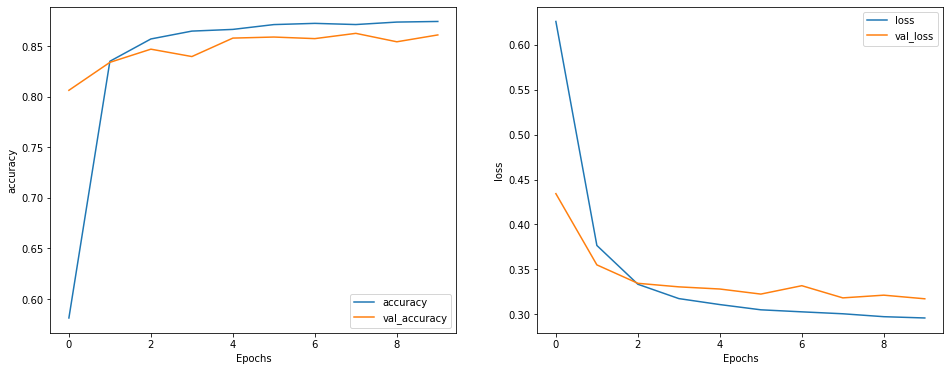

In [67]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

###2C: TODO 2 - IMDB Sentimental Analysis w/Transfer Learning

This section/code is taken from Chapter 4, entitled "Transfer Learning with BERT" *Advanced Natural Language Processing with TensorFlow 2* by Ashish Bansal , Packt Publishing Ltd 2021. 

NB: Unfortunately the GitHub code would not run (he compiled his on a MacOS Ubuntu system with a NVIDIA chip with local Python install which may have something to do with it) so we hand craft the code directly from the text.

Sources and additional text and description of models soyrced as noted in the notebook

####2C.1 Transfer Learning with GloVe embeddings

Code and walkthrough text (comments) from Bansal 2021 *Advanced NLP with Tensorflow 2*, Chapter 4 "Transfer Learning with BERT"

##### Data Load and Transform

In [68]:
#
# load train and test data sets from IMDB data set
#
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd

imdb_train, ds_info = tfds.load(name="imdb_reviews",
                                split="train",
                                with_info=True, as_supervised=True)

imdb_test = tfds.load(name="imdb_reviews", split="test", 
                       as_supervised=True)

In [69]:
#
# TRANSFORM
#
# tokenize and encode data set
# this code tokenizes the review text and constriucts a 
# vocabulary, the vocab is used to construct the tokenizer
#

# tokenizer = tfds.features.text.Tokenizer()      #deprecated
tokenizer = tfds.deprecated.text.Tokenizer()

vocabulary_set = set()
MAX_TOKENS = 0

for example, label in imdb_train:
  some_tokens = tokenizer.tokenize(example.numpy())
  if (MAX_TOKENS < len(some_tokens)):
    MAX_TOKENS = len(some_tokens)
  vocabulary_set.update(some_tokens)

In [70]:
#
# deprecated again
#
"""
imdb_encoder = tfds.features.text.TokenTextEncoder(vocabulary_set, 
                                                   lowercase=True, 
                                                   tokenizer=tokenizer)
"""

imdb_encoder = tfds.deprecated.text.TokenTextEncoder(vocabulary_set, 
                                                   lowercase=True,          # convert to lowercase before encoding
                                                   tokenizer=tokenizer)


vocab_size = imdb_encoder.vocab_size

print(vocab_size, MAX_TOKENS)

93931 2525


In [71]:
# 
# now that tokenizer is ready, data needs to be 
# tokenized, and sequences padded to max length
#


#
# transformation functions to be used with dataset
#
from tensorflow.keras.preprocessing import sequence


def encode_pad_transform(sample):
  encoded = imdb_encoder.encode(sample.numpy())
  pad = sequence.pad_sequences([encoded], padding='post',
                               maxlen=150)
  return np.array(pad[0], dtype=np.int64)


def encode_tf_fn(sample, label):
  encoded = tf.py_function(encode_pad_transform,
                           inp=[sample],
                           Tout=(tf.int64))
  encoded.set_shape([None])
  label.set_shape([])
  return encoded, label

In [72]:
#
# encode the data using custom functions defined above
#
encoded_train = imdb_train.map(encode_tf_fn, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)

encoded_test = imdb_test.map(encode_tf_fn, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [73]:
encoded_train

<ParallelMapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [74]:
encoded_test

<ParallelMapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

At this point, all the training and test data is ready for training: ie load and transform process is finished


##### Loading (pre-trained) GloVe embeddings

load pre-trained GloVe embeddings and use these as the weights of the embedding layer

In [75]:
# download and unzip embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-07-22 17:04:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-22 17:04:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-22 17:04:10--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Over 800MB download, four different files downloaded (and unzipped). Each file has a vocabulary of 400,000 words, main diff is the dimensions of the embeddings generated.

Format is straightforward, each line of text has multiple values separated by spaces. First item of each row is the word, rest of the items are the vaklues of the vector for each dimension. So for a 50 dimension embedding there will be 51 values on a line, one for the word and another for each of the 50 dimensions.

These vectors need to be loaded into memory

In [76]:
dict_w2v = {}

with open('glove.6B.50d.txt', 'r') as file:
  for line in file:
    tokens = line.split()
    word = tokens[0]
    vector = np.array(tokens[1:], dtype=np.float32)

    if vector.shape[0] == 50:
      dict_w2v[word] = vector
    else:
      print("There was an issue with " + word)

In [77]:
# check the vocab size
print("Dictionary Size: ", len(dict_w2v))

Dictionary Size:  400000


Once these vectors are loded, an embedding matrix needs to be created.

So far, we have a data set, its vocabulary, and a dictionary of GloVe words and their corresponding vectors, however there is no correlation between these two vocabularies. 

The way to connect them is through the creation of an embedding matrix.

In [78]:
embedding_dim = 50
embedding_matrix = np.zeros((imdb_encoder.vocab_size, embedding_dim))

When a pre-trained word list is used, finding a vector for each word in the training/test data set is not guaranteed.

After embedding matrix of zeros is initialized, it needs to be populated.

#####Populate embedded matrix

In [79]:
#
# populate the embedding matrix:
#
# For each word in the vocabulary of reviews, the corresponding vector is 
# retrieved from the GloVe dictionary. The ID of the word is retrieved 
# using the encoder, and then the embedding matrix enrty corresponding 
# to that entry is set to the retrived vector
#

unk_cnt = 0
unk_set = set()

for word in imdb_encoder.tokens:
  embedding_vector = dict_w2v.get(word)

  if embedding_vector is not None:
    tkn_id = imdb_encoder.encode(word)[0]
    embedding_matrix[tkn_id] = embedding_vector
  else:
    unk_cnt += 1
    unk_set.add(word)

In [80]:
# 
# print how many vocab words that arent found
#
print("Total unknown word count: ", unk_cnt)

Total unknown word count:  14553


#####2C.1a Double LSTM with frozen pre-trained weights (feature extraction model a)

This model freezes the pre-trained weights. NB that there are a large number of tokens (> 14,000) that have zero embedded vectors, ie the vocabulary is not defined (no match in the GloVe word list)

###### Set Global Variables

In [81]:
#
# set basic params
#
vocab_size = imdb_encoder.vocab_size    # len in chars

rnn_units = 64

BATCH_SIZE = 100

######Build Model (Model Function)

In [82]:
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense

#
# this function allows for building of model with same 
# architecture but diff hyperparams]
#
# NB model has an Embedding layer, two Bidirectional layers 
# and then the final Dense layer with the activation function
#
def build_model_bilstm(vocab_size, embedding_dim, 
                       rnn_units, batch_size, train_emb=False):
  
  model = tf.keras.Sequential([
                               Embedding(vocab_size, embedding_dim, mask_zero=True, 
                                         weights=[embedding_matrix], trainable=train_emb),
                               Bidirectional(LSTM(rnn_units, return_sequences=True, dropout=0.5)),
                               Bidirectional(LSTM(rnn_units, dropout=0.25)),
                               Dense(1, activation='sigmoid')
                               ])
  
  return model

In [83]:
# 
# build the feature extraction model and plug in embedding matrix
#
model_fe = build_model_bilstm(
    vocab_size = vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [84]:
model_fe.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          4696550   
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 128)        58880     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,854,375
Trainable params: 157,825
Non-trainable params: 4,696,550
_________________________________________________________________


In [85]:
model_fe.compile(
    loss='binary_crossentropy',                   # loss function for binary classification
    optimizer='adam',                             # decent optimizer choice for most cases
    metrics=['accuracy', 'Precision', 'Recall'
    ])

######Train Model

In [86]:
#
# prefetch for performance
#
encoded_train_batched = encoded_train.batch(BATCH_SIZE).prefetch(100)

model_fe.fit(encoded_train_batched, epochs=10)

# model_fe.fit(encoded_train.batch(BATCH_SIZE), epochs=10)

Epoch 1/10
250/250 [==============================] - 38s 94ms/step - loss: 0.5991 - accuracy: 0.6745 - precision: 0.6807 - recall: 0.6573
Epoch 2/10
250/250 [==============================] - 27s 108ms/step - loss: 0.5227 - accuracy: 0.7403 - precision: 0.7440 - recall: 0.7326
Epoch 3/10
250/250 [==============================] - 27s 109ms/step - loss: 0.4930 - accuracy: 0.7644 - precision: 0.7702 - recall: 0.7536
Epoch 4/10
250/250 [==============================] - 28s 110ms/step - loss: 0.4689 - accuracy: 0.7767 - precision: 0.7787 - recall: 0.7730
Epoch 5/10
250/250 [==============================] - 28s 110ms/step - loss: 0.4571 - accuracy: 0.7857 - precision: 0.7879 - recall: 0.7818
Epoch 6/10
250/250 [==============================] - 28s 110ms/step - loss: 0.4416 - accuracy: 0.7948 - precision: 0.7926 - recall: 0.7984
Epoch 7/10
250/250 [==============================] - 27s 109ms/step - loss: 0.4246 - accuracy: 0.8028 - precision: 0.8031 - recall: 0.8022
Epoch 8/10
250/250 [=

######Evaluate Model

In [111]:
#
# evaluate model on test data
#
model_fe.evaluate(encoded_test.batch(BATCH_SIZE))

250/250 [==============================] - 30s 120ms/step - loss: 0.3861 - accuracy: 0.8368 - precision: 0.8084 - recall: 0.8830


[0.3860918879508972,
 0.8368399739265442,
 0.8083937764167786,
 0.8829600214958191]

#####2C.1b Double LSTM with trainable pre-trained weights (feature extraction model b)

Fine tuning of the embeddings matrix

######Build the model

In [88]:
model_ft = build_model_bilstm(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE,
    train_emb=True
)

In [89]:
model_ft.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 50)          4696550   
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 128)        58880     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,854,375
Trainable params: 4,854,375
Non-trainable params: 0
_________________________________________________________________


In [90]:
model_ft.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy', 'Precision', 'Recall'])

######Train the model

In [91]:
model_ft.fit(encoded_train_batched, epochs=10)

Epoch 1/10
250/250 [==============================] - 38s 96ms/step - loss: 0.5660 - accuracy: 0.7042 - precision: 0.7046 - recall: 0.7033
Epoch 2/10
250/250 [==============================] - 27s 108ms/step - loss: 0.4123 - accuracy: 0.8121 - precision: 0.8141 - recall: 0.8090
Epoch 3/10
250/250 [==============================] - 27s 107ms/step - loss: 0.3346 - accuracy: 0.8577 - precision: 0.8596 - recall: 0.8550
Epoch 4/10
250/250 [==============================] - 28s 110ms/step - loss: 0.2832 - accuracy: 0.8808 - precision: 0.8825 - recall: 0.8786
Epoch 5/10
250/250 [==============================] - 27s 107ms/step - loss: 0.2382 - accuracy: 0.9043 - precision: 0.9049 - recall: 0.9036
Epoch 6/10
250/250 [==============================] - 27s 107ms/step - loss: 0.2081 - accuracy: 0.9194 - precision: 0.9221 - recall: 0.9162
Epoch 7/10
250/250 [==============================] - 27s 107ms/step - loss: 0.1852 - accuracy: 0.9281 - precision: 0.9290 - recall: 0.9270
Epoch 8/10
250/250 [=

######Evaluate the model

In [92]:
model_ft.evaluate(encoded_test.batch(BATCH_SIZE))

250/250 [==============================] - 28s 93ms/step - loss: 0.5526 - accuracy: 0.8616 - precision: 0.8290 - recall: 0.9112


[0.5526447892189026,
 0.8616399765014648,
 0.8290268778800964,
 0.9111999869346619]

####2C.2 Transfer Learning with BERT

Code and walkthrough text (comments) from Bansal 2021 *Advanced NLP with Tensorflow 2*, Chapter 4 "Transfer Learning with BERT"

#####Initialize Transformer

In [93]:
# install Hugging Face libraries

!pip install transformers==3.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 769 kB 15.7 MB/s 
     |████████████████████████████████| 1.2 MB 76.1 MB/s 
     |████████████████████████████████| 3.0 MB 64.8 MB/s 
     |████████████████████████████████| 880 kB 87.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=3e2480c5bc06d1e47cd456b3ac4c1d41db27bc36d579e1d0e64c045e2be0efd0
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [94]:
#import the BERT tokenizer
from transformers import BertTokenizer

bert_name = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(bert_name,
                                          add_special_tokens=True,
                                          do_lower_case=False,
                                          max_length=150,
                                          pad_to_max_length=True
                                          )

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

#####Some Tokenizer Examples

In [95]:
tokenizer.encode_plus(" Don't be lured", 
                      add_special_tokens=True,
                      max_length=9,
                      pad_to_max_length=True,
                      return_attention_mask=True,
                      return_token_type_ids=True)

{'input_ids': [101, 1790, 112, 189, 1129, 19615, 1181, 102, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0]}

In [96]:
tokenizer.encode_plus(" Don't be", " lured", 
                      add_special_tokens=True,
                      max_length=10,
                      pad_to_max_length=True,
                      return_attention_mask=True,
                      return_token_type_ids=True)

{'input_ids': [101, 1790, 112, 189, 1129, 102, 19615, 1181, 102, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 1, 1, 1, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]}

#####Load and Encode IMDB Data

In [97]:
#
# load train and test data sets from IMDB data set
#
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd

imdb_train, ds_info = tfds.load(name="imdb_reviews",
                                split="train",
                                with_info=True, as_supervised=True)

imdb_test = tfds.load(name="imdb_reviews", split="test", 
                       as_supervised=True)

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load dataset info from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:Reusing dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split train, from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load dataset info from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:Reusing dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


In [98]:
#
# function for encoding all IMDB inputs
#
def bert_encoder(review):
  txt = review.numpy().decode('utf-8')

  encoded = tokenizer.encode_plus(txt, add_special_tokens=True,
                      max_length=150,
                      pad_to_max_length=True,
                      return_attention_mask=True,
                      return_token_type_ids=True)
  
  return encoded['input_ids'], encoded['token_type_ids'], \
    encoded['attention_mask']

In [ ]:
#
# apply BERT encoder to all IMDB review data
#

bert_train = [bert_encoder(r) for r, l in imdb_train]
bert_lbl = [l for r, l in imdb_train]
bert_train = np.array(bert_train)
bert_lbl = tf.keras.utils.to_categorical(bert_lbl, num_classes=2)

In [100]:
#
# split training data into training and validation splits
#
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(bert_train,
                                                  bert_lbl, 
                                                  test_size=0.2,
                                                  random_state=42)

print(x_train.shape, y_train.shape)

(20000, 3, 150) (20000, 2)


In [101]:
#
# three input dictionaaries need to be created in tf.DataSet for use in training
#
tr_reviews, tr_segments, tr_masks = np.split(x_train, 3, axis=1)
val_reviews, val_segments, val_masks = np.split(x_val, 3, axis=1)

tr_reviews = tr_reviews.squeeze()
tr_segments = tr_segments.squeeze()
tr_masks = tr_masks.squeeze()

val_reviews = val_reviews.squeeze()
val_segments = val_segments.squeeze()
val_masks = val_masks.squeeze()

In [102]:
#
# convert into Datasets
#
def example_to_features(input_ids,attention_masks,token_type_ids,y):
  return{"input_ids": input_ids,
         "attention_mask": attention_masks,
         "token_type_ids": token_type_ids},y

train_ds = tf.data.Dataset.from_tensor_slices((tr_reviews,
                                          tr_masks, tr_segments, y_train)).\
                                          map(example_to_features).shuffle(100).batch(16)

valid_ds = tf.data.Dataset.from_tensor_slices((val_reviews, 
                                          val_masks, val_segments, y_val)).\
                                          map(example_to_features).shuffle(100).batch(16)

In [103]:
train_ds

<BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 150), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 150), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 150), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [104]:
valid_ds

<BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 150), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 150), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 150), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

#####Build the Model

In [105]:
from transformers import TFBertForSequenceClassification

bert_model = TFBertForSequenceClassification.from_pretrained(bert_name)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [106]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [107]:
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_43 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


#####Train the model

In [108]:
print("...fine-tuning BERT on IMDB data set...")

bert_history = bert_model.fit(train_ds, epochs=3,
                              validation_data=valid_ds)

...fine-tuning BERT on IMDB data set...
Epoch 1/3
1250/1250 [==============================] - 696s 542ms/step - loss: 0.3485 - accuracy: 0.8481 - val_loss: 0.2682 - val_accuracy: 0.8834
Epoch 2/3
1250/1250 [==============================] - 681s 545ms/step - loss: 0.1927 - accuracy: 0.9281 - val_loss: 0.3557 - val_accuracy: 0.8746
Epoch 3/3
1250/1250 [==============================] - 681s 545ms/step - loss: 0.1005 - accuracy: 0.9664 - val_loss: 0.3895 - val_accuracy: 0.8906


#####Evaluate the model

In [ ]:
#
# prep test data as we did for training data
#
bert_test = [bert_encoder(r) for r,l in imdb_test]
bert_tst_lbl = [l for r, l in imdb_test]

bert_test2 = np.array(bert_test)
bert_tst_lbl2 = tf.keras.utils.to_categorical (bert_tst_lbl,
                                               num_classes=2)

ts_reviews, ts_segments, ts_masks = np.split(bert_test2, 3, axis=1)
ts_reviews = ts_reviews.squeeze()
ts_segments = ts_segments.squeeze()
ts_masks = ts_masks.squeeze()

test_ds = tf.data.Dataset.from_tensor_slices((ts_reviews,
                                              ts_masks, ts_segments, bert_tst_lbl2)).\
                                              map(example_to_features).shuffle(100).batch(16)

In [110]:
bert_model.evaluate(test_ds)

1563/1563 [==============================] - 268s 172ms/step - loss: 0.4272 - accuracy: 0.8789


[0.4272250533103943, 0.8788800239562988]

###Part 2 Summary Table

| Method | Test Accuracy | Remarks |
| --- | --- | --- |
| (2A) Single LSTM w/embedding | 0.853 | Baseline |
| (2B) Double layer LSTM w/embedding | 0.859 | almost the same result as single LSTM |
| (2C.1a) Transfer learning: Double LSTM GloVe embeddings (frozen pre-trained) | 0.836 | worse than straight LSTM models |
| (2C.1b) Transfer learing: Double LSTM GloVe embeddings (unfrozen pre-trained) | 0.861 | better now that we can train the GloVe embeddings, better than baseline slightly |
| (2C.2) Transfer learning with BERT | 0.878 | encoding takes a while but good performance |


## Part 3: NLP using Transformers 

In Part 3 we will look at the Transformer architecture and how it can be used in a specific NLP task, machine translation (from English to Spanish).

Please refer to Chapter 11 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864) for additional information.


Useful sources and references for Part 3:

- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part03_transformer.ipynb
- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb 


### Setup

In [112]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2022-07-22 18:41:12--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 142.251.31.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.03s   

2022-07-22 18:41:12 (90.1 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



In [113]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

In [114]:
import random
print(random.choice(text_pairs))

("I've married the wrong person.", '[start] Me he casado con la persona equivocada. [end]')


In [115]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

**Vectorizing the English and Spanish text pairs**

In [116]:
import tensorflow as tf
import string
import re

from tensorflow import keras
from tensorflow.keras import layers

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

**Preparing datasets for the translation task**

In [117]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [118]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


### The Transformer encoder

In [119]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

### The Transformer decoder

In [120]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

### Putting it all together: A Transformer for machine translation

**PositionalEmbedding layer**

In [121]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

**End-to-end Transformer**

In [122]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

**Training the sequence-to-sequence Transformer**

In [123]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
1302/1302 [==============================] - 91s 67ms/step - loss: 1.6768 - accuracy: 0.4176 - val_loss: 1.3287 - val_accuracy: 0.5077
Epoch 2/10
1302/1302 [==============================] - 88s 68ms/step - loss: 1.3410 - accuracy: 0.5320 - val_loss: 1.1722 - val_accuracy: 0.5651
Epoch 3/10
1302/1302 [==============================] - 88s 68ms/step - loss: 1.1892 - accuracy: 0.5808 - val_loss: 1.0925 - val_accuracy: 0.6006
Epoch 4/10
1302/1302 [==============================] - 88s 68ms/step - loss: 1.1011 - accuracy: 0.6127 - val_loss: 1.0534 - val_accuracy: 0.6195
Epoch 5/10
1302/1302 [==============================] - 88s 68ms/step - loss: 1.0517 - accuracy: 0.6352 - val_loss: 1.0293 - val_accuracy: 0.6305
Epoch 6/10
1302/1302 [==============================] - 89s 68ms/step - loss: 1.0208 - accuracy: 0.6511 - val_loss: 1.0168 - val_accuracy: 0.6387
Epoch 7/10
1302/1302 [==============================] - 88s 68ms/step - loss: 0.9975 - accuracy: 0.6640 - val_loss: 1.0123 -

**Translating new sentences with our Transformer model**

In [124]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
I use Firefox.
[start] yo como [UNK] [end]
-
You shouldn't trust your memory so much.
[start] no deberías pasar lo que es tan de mi salud [end]
-
Tom took the microphone away from Mary.
[start] tom se tomó la [UNK] de mary [end]
-
He's definitely not coming.
[start] Él no viene a la vez [end]
-
Would you mind showing Tom around the city?
[start] te importa que me [UNK] la ciudad [end]
-
Why did you kiss me?
[start] por qué me lo [UNK] [end]
-
I have dandruff.
[start] tengo que [UNK] [end]
-
Do you want a drink?
[start] quieres un poco [end]
-
He didn't acknowledge defeat.
[start] Él no se [UNK] [end]
-
The operation had to be kept secret.
[start] la la [UNK] tenía que tener que [UNK] [end]
-
Are both of you ready to go?
[start] los dos están listo para ir [end]
-
Everything was ready for the trip.
[start] todo estaba listo para el viaje [end]
-
He's my best friend. It's as if he were my brother.
[start] es mi mejor amigo que él fuera el amigo de que yo fuera mi hermano [end]
-
She's 

## Appendix A: More on BERT

#### BERT Overview


**BERT** stands for **B**idirectional **E**ncoder **R**epresentations from **T**ransformers. Let us understand this in detail each word .

* **Bidirectional** - to understand the text you’re looking you’ll have to look back (at the previous words) and forward (at the next words)
* **Transformers** - [The Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. his in a sentence refers to Jim).
* **(Pre-trained) contextualized word embeddings** - [The ELMO paper](https://arxiv.org/pdf/1802.05365v2.pdf) introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence.



---


From Wikipedia contributors. "BERT (language model)." Wikipedia, The Free Encyclopedia. Wikipedia, The Free Encyclopedia, 25 Jun. 2022. Web. 17 Jul. 2022.


*BERT*

Bidirectional Encoder Representations from Transformers (BERT) is a transformer-based machine learning technique for natural language processing (NLP) pre-training developed by Google. BERT was created and published in 2018 by Jacob Devlin and his colleagues from Google.[1][2] In 2019, Google announced that it had begun leveraging BERT in its search engine, and by late 2020 it was using BERT in almost every English-language query. A 2020 literature survey concluded that "in a little over a year, BERT has become a ubiquitous baseline in NLP experiments", counting over 150 research publications analyzing and improving the model.[3]

The original English-language BERT has two models:[1] (1) the BERTBASE: 12 encoders with 12 bidirectional self-attention heads, and (2) the BERTLARGE: 24 encoders with 16 bidirectional self-attention heads. Both models are pre-trained from unlabeled data extracted from the BooksCorpus[4] with 800M words and English Wikipedia with 2,500M words.


*Architecture*

BERT is at its core a transformer language model with a variable number of encoder layers and self-attention heads. The architecture is "almost identical" to the original transformer implementation in Vaswani et al. (2017).[5]

BERT was pretrained on two tasks: language modelling (15% of tokens were masked and BERT was trained to predict them from context) and next sentence prediction (BERT was trained to predict if a chosen next sentence was probable or not given the first sentence). As a result of the training process, BERT learns contextual embeddings for words. After pretraining, which is computationally expensive, BERT can be finetuned with less resources on smaller datasets to optimize its performance on specific tasks.[1][6]



---


https://www.marketingaiinstitute.com/blog/bert-google#:~:text=BERT%20uses%20AI%20in%20the,%2Dby%2Done%20in%20order.


BERT uses AI in the form of natural language processing (NLP), natural language understanding (NLU), and sentiment analysis to process every word in a search query in relation to all the other words in a sentence.

In the past, Google used to process words one-by-one in order. The difference in results between the old and new approach can be dramatic. 

Google offers the example of a search like "2019 brazil traveler to usa need a visa." In the past, Google would have interpreted this search as a US traveler looking for a visa to Brazil. That's because Google didn't account for prepositions and context inherent in human language. In this example, Google would not have taken the word "to" into account. That changes the meaning of the search.

Compare that to BERT's approach. BERT takes the whole sentence into account, including prepositions. In this example, BERT now understands the searcher is a Brazilian looking for a US visa—not the other way around. 

---

####BERT Architecture 


The original BERT model was developed and trained by Google using TensorFlow. BERT is released in two sizes **BERTBASE** and **BERTLARGE**. 

The BASE model is used to measure the performance of the architecture comparable to another architecture and the LARGE model produces state-of-the-art results that were reported in the research paper.

One of the main reasons for the good performance of BERT on different NLP tasks was the use of **Semi-Supervised Learning**. This means the model is trained for a specific task that enables it to understand the patterns of the language. After training the model (BERT) has language processing capabilities that can be used to empower other models that we build and train using supervised learning.

**BERT** is basically an Encoder stack of transformer architecture. A transformer architecture is an encoder-decoder network that uses self-attention on the encoder side and attention on the decoder side. 

**BERTBASE** has 12 layers in the Encoder stack while **BERTLARGE** has 24 layers in the Encoder stack. These are more than the Transformer architecture described in the original paper (6 encoder layers). 

**BERT** architectures (BASE and LARGE) also have larger feedforward-networks (768 and 1024 hidden units respectively), and more attention heads (12 and 16 respectively) than the Transformer architecture suggested in the original paper. It contains 512 hidden units and 8 attention heads. 

**BERTBASE** contains 110M parameters while BERTLARGE has 340M parameters.

So in summary
* **BERT-Base**: 12 layer Encoder / Decoder, d = 768, 110M parameters
* **BERT-Large**: 24 layer Encoder / Decoder, d = 1024, 340M parameters

where d is the dimensionality of the final hidden vector output by BERT. Both of these have a Cased and an Uncased version (the Uncased version converts all words to lowercase).

![](https://media.geeksforgeeks.org/wp-content/uploads/20200407004114/bert-base-and-large.jpg)

This model takes CLS token as input first, then it is followed by a sequence of words as input. Here CLS is a classification token. It then passes the input to the above layers. Each layer applies self-attention, passes the result through a feedforward network after then it hands off to the next encoder.

The model outputs a vector of hidden size (768 for BERT BASE). If we want to output a classifier from this model we can take the output corresponding to CLS token.
![](https://media.geeksforgeeks.org/wp-content/uploads/20200407005130/BERT-embedding-output.jpg)

####Core Idea of BERT

What is language modeling really about? Which problem are language models trying to solve? Basically, their task is to “fill in the blank” based on context. For example, given

“The woman went to the store and bought a _____ of shoes.”

a language model might complete this sentence by saying that the word “cart” would fill the blank 20% of the time and the word “pair” 80% of the time.

In the pre-BERT world, a language model would have looked at this text sequence during training from either left-to-right or combined left-to-right and right-to-left. This one-directional approach works well for generating sentences — we can predict the next word, append that to the sequence, then predict the next to next word until we have a complete sentence.

Now enters BERT, a language model which is bidirectionally trained (this is also its key technical innovation). This means we can now have a deeper sense of language context and flow compared to the single-direction language models.

Instead of predicting the next word in a sequence, BERT makes use of a novel technique called **Masked LM** (MLM): it randomly masks words in the sentence and then it tries to predict them. Masking means that the model looks in both directions and it uses the full context of the sentence, both left and right surroundings, in order to predict the masked word. Unlike the previous language models, it takes both the previous and next tokens into account at the same time. The existing combined left-to-right and right-to-left LSTM based models were missing this “same-time part”. (It might be more accurate to say that BERT is non-directional though.)

But why is this non-directional approach so powerful? 

Pre-trained language representations can either be context-free or context-based. Context-based representations can then be unidirectional or bidirectional. Context-free models like word2vec generate a single word embedding representation (a vector of numbers) for each word in the vocabulary.

For example, the word “bank” would have the same context-free representation in “bank account” and “bank of the river.” On the other hand, context-based models generate a representation of each word that is based on the other words in the sentence. For example, in the sentence “I accessed the bank account,” a unidirectional contextual model would represent “bank” based on “I accessed the” but not “account.” However, BERT represents “bank” using both its previous and next context — “I accessed the … account” — starting from the very bottom of a deep neural network, making it deeply bidirectional.
![](https://i0.wp.com/mlexplained.com/wp-content/uploads/2019/01/Screen-Shot-2019-01-03-at-11.22.11-AM.png?fit=750%2C192)

It’s evident from the above image: BERT is bi-directional, GPT is unidirectional (information flows only from left-to-right), and ELMO is shallowly bidirectional.

BERT is based on the Transformer model architecture, instead of LSTMs. We will very soon see the model details of BERT, but in general:

A Transformer works by performing a small, constant number of steps. In each step, it applies an attention mechanism to understand relationships between all words in a sentence, regardless of their respective position. For example, given the sentence,  “I arrived at the bank after crossing the river”, to determine that the word “bank” refers to the shore of a river and not a financial institution, the Transformer can learn to immediately pay attention to the word “river” and make this decision in just one step.

####How does BERT work?

BERT relies on a Transformer (the attention mechanism that learns contextual relationships between words in a text). A basic Transformer consists of an encoder to read the text input and a decoder to produce a prediction for the task. Since BERT’s goal is to generate a language representation model, it only needs the encoder part. The input to the encoder for BERT is a sequence of tokens, which are first converted into vectors and then processed in the neural network. But before processing can start, BERT needs the input to be massaged and decorated with some extra metadata:

* **Token embeddings**: A  token is added to the input word tokens at the beginning of the first sentence and a  token is inserted at the end of each sentence.
* **Segment embeddings**: A marker indicating Sentence A or Sentence B is added to each token. This allows the encoder to distinguish between sentences.
* **Positional embeddings**: A positional embedding is added to each token to indicate its position in the sentence.
![](https://towardsml.files.wordpress.com/2019/09/input.png?w=810)
The input representation for BERT: The input embeddings are the sum of the token embeddings, the segmentation embeddings and the position embeddings.
 

Essentially, the Transformer stacks a layer that maps sequences to sequences, so the output is also a sequence of vectors with a 1:1 correspondence between input and output tokens at the same index. And as we learnt earlier, BERT does not try to predict the next word in the sentence. 

BERT is pre-trained on two NLP tasks:

**1. Masked Language Modeling (MLM)**

BERT is designed as a deeply bidirectional model. The network effectively captures information from both the right and left context of a token from the first layer itself and all the way through to the last layer.

Traditionally, we had language models either trained to predict the next word in a sentence (right-to-left context used in GPT) or language models that were trained on a left-to-right context. This made our models susceptible to errors due to loss in information.

Let us take an example to understand it better

Let’s say we have a sentence – “I love to read data science blogs on Kaggle”. We want to train a bi-directional language model. Instead of trying to predict the next word in the sequence, we can build a model to predict a missing word from within the sequence itself.

Let’s replace “Kaggle” with “[MASK]”. This is a token to denote that the token is missing. We’ll then train the model in such a way that it should be able to predict “Kaggle” as the missing token: “I love to read data science blogs on [MASK].”

This is the crux of a Masked Language Model. The authors of BERT also include some caveats to further improve this technique:

To prevent the model from focusing too much on a particular position or tokens that are masked, the researchers randomly masked 15% of the words.

The masked words were not always replaced by the masked tokens [MASK] because the [MASK] token would never appear during fine-tuning.

So, the researchers used the below technique:

* 80% of the time the words were replaced with the masked token [MASK]
* 10% of the time the words were replaced with random words
* 10% of the time the words were left unchanged


**2. Next Sentence Prediction (NSP)**

**Masked Language Models (MLMs)** learn to understand the relationship between words. Additionally, BERT is also trained on the task of Next Sentence Prediction for tasks that require an understanding of the relationship between sentences.

In order to understand relationship between two sentences, BERT training process also uses next sentence prediction. A pre-trained model with this kind of understanding is relevant for tasks like question answering. During training the model gets as input pairs of sentences and it learns to predict if the second sentence is the next sentence in the original text as well.

As we have seen earlier, BERT separates sentences with a special [SEP] token. During training the model is fed with two input sentences at a time such that:

* 50% of the time the second sentence comes after the first one.
* 50% of the time it is a a random sentence from the full corpus.

BERT is then required to predict whether the second sentence is random or not, with the assumption that the random sentence will be disconnected from the first sentence:
![](https://towardsml.files.wordpress.com/2019/09/nsp-1.png)

To predict if the second sentence is connected to the first one or not, basically the complete input sequence goes through the Transformer based model, the output of the [CLS] token is transformed into a 2×1 shaped vector using a simple classification layer, and the IsNext-Label is assigned using softmax.

The model is trained with both Masked LM and Next Sentence Prediction together. This is to minimize the combined loss function of the two strategies — “together is better”.

### Another BERT Example (CoLA data set)

This sourced Sanagapati 2020: *Knowledge Graph & NLP Tutorial-(BERT,spaCy,NLTK)* by Pavan Sanagapati 2020 

Available here: https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk/notebook) 

With code available at https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk/notebook.

####Setup and Data Load

Let us install the pytorch interface for BERT by Hugging Face. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) I have selected the pytorch interface because it strikes a nice balance between the high-level APIs and tensorflow code .

In [1]:
# note this requires a runtime restart after packafge install
!pip install pytorch-pretrained-bert pytorch-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import Libraries

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We use *The Corpus of Linguistic Acceptability (CoLA) dataset* for single sentence classification. Downloaded and installed on Google Drive for development here.

It's a set of sentences labeled as grammatically correct or incorrect. The data is as follows:

Column 1: the code representing the source of the sentence.

Column 2: the acceptability judgment label (0=unacceptable, 1=acceptable).

Column 3: the acceptability judgment as originally notated by the author.

Column 4: the sentence.

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import glob
import os

os.chdir("/content/drive/MyDrive/google_colab/deep_learning/Assignment 5/cola_public")

In [5]:
df = pd.read_csv("./raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [7]:
df.shape

(8551, 4)

In [8]:
df.sample(10)

,sentence_source,label,label_notes,sentence
3346,l-93,1,NaN,I presented a solution yesterday.
7050,sgww85,1,NaN,She goes and buys some whiskey.
8361,ad03,0,*,Benjamin said he would give the cloak to Lee a...
8173,ad03,0,*,Keep myself clean!
1989,r-67,1,NaN,That the sun was out is obvious.
3955,ks08,1,NaN,Historians believe FDR to be our most effectiv...
2307,l-93,1,NaN,Linda taped the label to the cover.
8154,ad03,1,NaN,People were playing on the beach.
5288,b_82,0,*,The book to whom did you give.
4712,ks08,1,NaN,He will keep up with their expectations.


####Parse and Transform Data

In [9]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

Next, import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 906820.22B/s]


Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:

* **input ids**: a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary
* **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
* **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
* **labels**: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

Although we can have variable length input sentences, BERT does requires our input arrays to be the same size. I addressed this by first choosing a maximum sentence length, and then padding and truncating our inputs until every input sequence is of the same length.

* To "pad" our inputs in this context means that if a sentence is shorter than the maximum sentence length, we simply add 0s to the end of the sequence until it is the maximum sentence length.

* If a sentence is longer than the maximum sentence length, then we simply truncate the end of the sequence, discarding anything that does not fit into our maximum sentence length.

I padded and truncated the sequences so that they all become of length MAX_LEN ("post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning) .

pad_sequences is a utility function that we're borrowing from Keras. It simply handles the truncating and padding of Python lists.

In [11]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [12]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [13]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [14]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [15]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [16]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [17]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

####Train Model (2 hrs + to build)

Now that our input data is properly formatted, it's time to fine tune the BERT model.

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.

We'll load **BertForSequenceClassification**. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

**Structure of Fine-Tuning Model**

As we've showed beforehand, the first token of every sequence is the special classification token ([CLS]). Unlike the hidden state vector corresponding to a normal word token, the hidden state corresponding to this special token is designated by the authors of BERT as an aggregate representation of the whole sentence used for classification tasks. As such, when we feed in an input sentence to our model during training, the output is the length 768 hidden state vector corresponding to this token. The additional layer that we've added on top consists of untrained linear neurons of size [hidden_state, number_of_labels], so [768,2], meaning that the output of BERT plus our classification layer is a vector of two numbers representing the "score" for "grammatical/non-grammatical" that are then fed into cross-entropy loss.

**The Fine-Tuning Process**

Because the pre-trained BERT layers already encode a lot of information about the language, training the classifier is relatively inexpensive. Rather than training every layer in a large model from scratch, it's as if we have already trained the bottom layers 95% of where they need to be, and only really need to train the top layer, with a bit of tweaking going on in the lower levels to accomodate our task.

Sometimes practicioners will opt to "freeze" certain layers when fine-tuning, or to apply different learning rates, apply diminishing learning rates, etc. all in an effort to preserve the good quality weights in the network and speed up training (often considerably). In fact, recent research on BERT specifically has demonstrated that freezing the majority of the weights results in only minimal accuracy declines, but there are exceptions and broader rules of transfer learning that should also be considered. For example, if your task and fine-tuning dataset is very different from the dataset used to train the transfer learning model, freezing the weights may not be a good idea. We'll cover the broader scope of transfer learning in NLP in a future post.

OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

In [18]:
#
# Load BertForSequenceClassification, the pretrained BERT model 
# with a single linear classification layer on top. 
#
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

100%|██████████| 407873900/407873900 [00:13<00:00, 29137711.52B/s]


Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4

In [19]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]

In [20]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)

t_total value of -1 results in schedule not being applied


For each pass in the training loop we have a training phase and a validation phase. 

At each pass we need to:

**Training loop:**

* Tell the model to compute gradients by setting the model in train mode
* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
* Forward pass (feed input data through the network)
* Backward pass (backpropagation)
* Tell the network to update parameters with optimizer.step()
* Track variables for monitoring progress

**Evalution loop:**

* Tell the model not to compute gradients by setting th emodel in evaluation mode
* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Forward pass (feed input data through the network)
* Compute loss on our validation data and track variables for monitoring progress

In [21]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [22]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs 
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.5060617022865541


Epoch:  50%|█████     | 1/2 [58:47<58:47, 3527.88s/it]

Validation Accuracy: 0.7908950617283951
Train loss: 0.25306056121449255


Epoch: 100%|██████████| 2/2 [1:59:22<00:00, 3581.30s/it]

Validation Accuracy: 0.8236882716049382


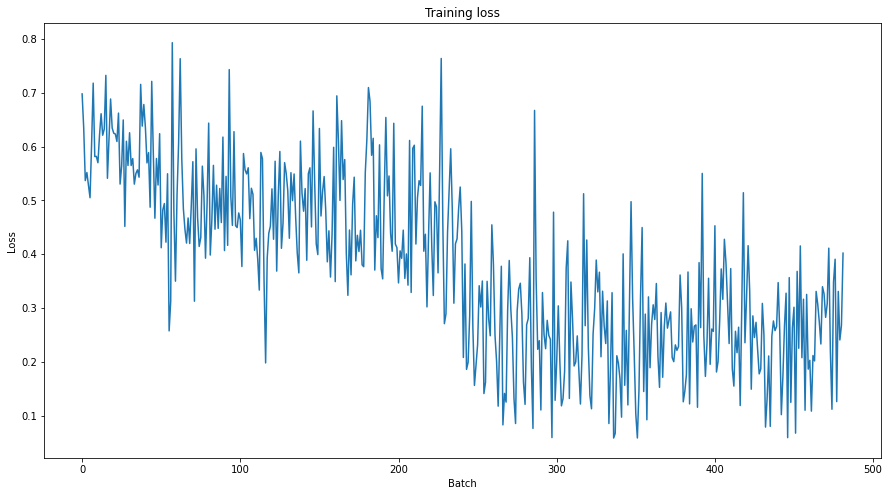

In [23]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

####Evaluate Model

In [24]:
df = pd.read_csv("./raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [25]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [26]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
 # batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [27]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [28]:
print(len(matthews_set))

17


In [29]:
print(matthews_set[0])

0.049286405809014416


## Appendix B: Text Summarization Overview and Techniques

###Sources

(Ananthakrishnan 2019) *Data Scientist’s Guide to Summarization* by Abhinaya Ananthakrishnan Mar 2019. Available here: https://medium.com/@abhinaya08/

(Dubey 2018) *Understand Text Summarization and create your own summarizer in python* by Praveen Dubey Dec 2018 available here: https://towardsdatascience.com/understand-text-summarization-and-create-your-own-summarizer-in-python-b26a9f09fc70

*A-Z Guide to Text Summarization in Python for Beginners* available here: https://www.projectpro.io/article/text-summarization-python-nlp/546

(Shrivarsheni 2020) *Text Summarization Approaches for NLP – Practical Guide with Generative Examples* by Shrivarsheni, Oct 2020 available here: https://www.machinelearningplus.com/nlp/text-summarization-approaches-nlp-example/

###The Problem

from https://towardsdatascience.com/understand-text-summarization-and-create-your-own-summarizer-in-python-b26a9f09fc70

*How text summarization works*

In general there are two types of summarization, abstractive and extractive summarization.

I. Abstractive Summarization: Abstractive methods select words based on semantic understanding, even those words did not appear in the source documents. It aims at producing important material in a new way. They interpret and examine the text using advanced natural language techniques in order to generate a new shorter text that conveys the most critical information from the original text.
It can be correlated to the way human reads a text article or blog post and then summarizes in their own word.

*Input document → understand context → semantics → create own summary.*


II. Extractive Summarization: Extractive methods attempt to summarize articles by selecting a subset of words that retain the most important points.

This approach weights the important part of sentences and uses the same to form the summary. Different algorithm and techniques are used to define weights for the sentences and further rank them based on importance and similarity among each other.

*Input document → sentences similarity → weight sentences → select sentences with higher rank.*

Purely extractive summaries often times give better results compared to automatic abstractive summaries. This is because of the fact that abstractive summarization methods cope with problems such as semantic representation,
inference and natural language generation which is relatively harder than data-driven approaches such as sentence extraction.


*Approach*

There are many techniques available to generate extractive summarization. To keep it simple, I will be using an unsupervised learning approach to find the sentences similarity and rank them. One benefit of this will be, you don’t need to train and build a model prior start using it for your project.

*NB*

NB: It’s good to understand Cosine similarity to make the best use of code you are going to see. Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. Since we will be representing our sentences as the bunch of vectors, we can use it to find the similarity among sentences. Its measures cosine of the angle between vectors. Angle will be 0 if sentences are similar.

###Extractive Techniques

Extractive summarization techniques select relevant phrases from the input document and concatenate them to form sentences. These are very popular in the industry as they are very easy to implement. They use existing natural language phrases and are reasonably accurate. Additionally, since they are unsupervised techniques, they are ridiculously fast. On the other hand, as these techniques only play around with the order of sentences in the document to summarize they do not do as great a job as humans to provide context.

####Example 1 (Dubey 2018)

From https://towardsdatascience.com/understand-text-summarization-and-create-your-own-summarizer-in-python-b26a9f09fc70


*There are many techniques available to generate extractive summarization. To keep it simple, I will be using an unsupervised learning approach to find the sentences similarity and rank them. One benefit of this will be, you don’t need to train and build a model prior start using it for your project.*

*It’s good to understand Cosine similarity to make the best use of code you are going to see. Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. Since we will be representing our sentences as the bunch of vectors, we can use it to find the similarity among sentences. Its measures cosine of the angle between vectors. Angle will be 0 if sentences are similar.*

######Imports and Setup

In [30]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import glob
import os

os.chdir("/content/drive/MyDrive/google_colab/deep_learning/Assignment 6 (Wildcards)/")

In [32]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [33]:
#!/usr/bin/env python
# coding: utf-8

from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx

######Utility Functions

In [34]:
#
# updated to support specific format of chapter/txt
#
def read_chapter(file_name):

    file = open(file_name, "r")
    filedata = file.readlines()

    print ("# of lines in ", file_name, ":", len(filedata) )

    #article = filedata[0].split(". ")
    #article = filedata[2].split(". ")
    
    sentences = []
    line_num = 0

    #
    # for each line parse sentences, add to 
    # sentence array
    #
    for line in filedata:
      #print("line: ", line)                # debug code      
      
      ln = filedata[line_num].split(". ")   # split line into sentences
          
      for sentence in ln:
        #print("sentence: ", sentence)      # debug code

        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
    
      sentences.pop() 

      line_num += 1
    
    return sentences

In [35]:
def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)

In [36]:
def build_similarity_matrix(sentences, stop_words):
  
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix

In [37]:
def generate_summary(file_name, top_n=5):
    stop_words = stopwords.words('english')
    summarize_text = []

    # Step 1 - Read text anc split it
    sentences = read_chapter(file_name)

    #print("sentences[0]: ", sentences[0])                # debug code
    print("# of sentences: ", len(sentences))            # debug code

    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)

    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph)

    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
    print("Indexes of top ranked_sentence order are ", ranked_sentence)    

    for i in range(top_n):
      summarize_text.append(" ".join(ranked_sentence[i][1]))

    # Step 5 - Offcourse, output the summarize texr
    print("Summarize Text: \n", ". ".join(summarize_text))

#####Main: Generate Summary

In [38]:
# let's begin
#generate_summary( "msft.txt", 2)
generate_summary( "./ontology.txt", 2)

# of lines in  ./ontology.txt : 63
# of sentences:  154
Indexes of top ranked_sentence order are  [(0.01416477477081454, ['', 'Why', 'did', 'the', 'rivers', 'flood', 'some', 'years', 'and', 'not', 'others?', '', 'Why', 'did', 'the', 'sun', 'rise', 'every', 'day?', '', 'Why', 'did', 'the', 'herds', 'that', 'the', 'depended', 'on', 'for', 'food', 'and', 'other', 'utilities', 'of', 'day', 'to', 'day', 'living', 'show', 'up', 'some', 'years', 'and', 'be', 'absent', 'others?', '', 'What', 'happened', 'to', 'the', 'Soul', 'after', 'death?', '', 'Was', 'there', 'a', 'Soul?', '', 'It', 'was', 'these', 'questions', 'that', 'plagued', 'the', 'ancients', 'and', 'that', 'formed', 'their', 'perception', 'of', 'their', 'reality,', 'or', 'their', 'world']), (0.01279913173086477, ['', 'And', 'how', 'could', 'it?', '', 'There', 'was', 'nothing', 'in', 'the', 'world', 'around', 'them', 'that', 'would', 'indicate', 'this', 'separation']), (0.011689309751707979, ['', 'In', 'this', 'sense', 'we', 'can', 'l

####Example 2: Using gensim (Ananthakrishnan 2019)

See https://medium.com/@abhinaya08/data-scientists-guide-to-summarization-dde46b30b4c3

#####Gensim Algorithm Overview

The Gensim summarization module implements TextRank, an unsupervised algorithm based on weighted-graphs from a paper by Mihalcea et al. It is built on top of the popular PageRank algorithm that Google used for ranking.

After pre-processing text this algorithm builds graph with sentences as nodes and chooses the sentences with highest page rank to summarize the document

What is TextRank?

TextRank is based on PageRank algorithm that is used on Google Search Engine. In simple words, it prefers pages which has higher number of pages hitting it. Traditionally, the links between pages are expressed by matrix as shown in the image below. This matrix is then converted to a transition probability matrix by dividing the sum of links in each page which influences the path of the surfer.


TextRank Overview
In the original “TextRank” algorithm the weights of an edge between two sentences is the percentage of words appearing in both of them.


Similarity calculation between sentences
However, the updated algorithm uses Okapi BM25 function to see how similar the sentences are. BM25 / Okapi-BM25 is a ranking function widely used as the state of the art for Information Retrieval tasks. BM25 is a variation of the TF-IDF model using a probabilistic model.


Improved similarity with BM25
In a nutshell, this function penalizes words that appears in more than half the documents of the collection by giving them a negative value.

The gensim algorithm does a good job at creating both long and short summaries. Another cool feature of gensim is that we can get a list of top keywords chosen by the algorithm. This feature can come in handy for other NLP tasks, where we want to use “TextRank” to select words from a document instead of “Bag of Words” or “TF-IDF”. Gensim also has a well-maintained repository and has an active community which is an added asset to using this algorithm.

#####Sample Code

In [39]:
import re
import nltk

from gensim.summarization import summarize
from gensim.summarization import keywords

file = open('./ontology.txt', "r")
filedata = file.readlines()

article_text = ""

for line in filedata:  
  article_text += line

print("==================================SUMMARY===================================")
print (summarize(article_text,ratio=0.01))

print("==================================KEYWORDS===================================")
print (keywords(article_text,ratio=0.01))

==================================SUMMARY===================================
Having said that, and not disparaging the importance and significance of these developments in advancing mankind, if you look at some the hunter-gatherer societies that exist today, societies that very much reflect this very ancient form of existence and dependence upon nature for survival, forms of society that pre-date the evolution of Western civilization for several tens if not hundreds of thousands of years - in the recesses of Alaska, the Amazon basin, Australian outback or central and eastern Africa - you will find the same belief systems of ancient man that reflect a worldview of interconnectedness, a spectrum of reality that includes the earthly material world as well as the spiritual world (theology), where there exists a fundamental reliance, and belief, on the unknown and unknowable creative principle from which the universe was created and which in turn preserves it, across which the cycle of time

####Example 3: Using Summa (Ananthakrishnan 2019)

See https://medium.com/@abhinaya08/data-scientists-guide-to-summarization-dde46b30b4c3


The summa summarizer is another algorithm which is an improvisation of the gensim algorithm. It also uses TextRank but with optimizations on similarity functions. Like gensim, summa also generates keywords.

#####Sample Code

In [40]:
!pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 3.4 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=81bbb27c6e84955859ae2a0e7b2b1e63cc5f9f2b3fde35139cc11f575189baa8
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [41]:
import bs4 as bs  
import re
import nltk

from summa import summarizer
from summa import keywords

file = open('./ontology.txt', "r")
filedata = file.readlines()

article_text = ""

for line in filedata:  
  article_text += line

print("==================================SUMMARY===================================")
print (summarizer.summarize(article_text,ratio=0.1))

print("==================================KEYWORDS===================================")
print (keywords.keywords(article_text,ratio=0.1))

==================================SUMMARY===================================
Having said that, and not disparaging the importance and significance of these developments in advancing mankind, if you look at some the hunter-gatherer societies that exist today, societies that very much reflect this very ancient form of existence and dependence upon nature for survival, forms of society that pre-date the evolution of Western civilization for several tens if not hundreds of thousands of years - in the recesses of Alaska, the Amazon basin, Australian outback or central and eastern Africa - you will find the same belief systems of ancient man that reflect a worldview of interconnectedness, a spectrum of reality that includes the earthly material world as well as the spiritual world (theology), where there exists a fundamental reliance, and belief, on the unknown and unknowable creative principle from which the universe was created and which in turn preserves it, across which the cycle of time

####Example 4: NLTK Example

From https://www.mygreatlearning.com/blog/text-summarization-in-python/#Complete%20Code

#####Sample Code

In [42]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

In [43]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [44]:
file = open('./ontology.txt', "r")
filedata = file.readlines()

text = ""

for line in filedata:  
  text += line

In [45]:
# tokenize the text
stopWords = set(stopwords.words("english"))
words = word_tokenize(article_text)

In [46]:
# create freq table to score each word
freqTable = dict()

for word in words:
  word = word.lower()
  if word in stopWords:
    continue
  if word in freqTable:
    freqTable[word] += 1
  else:
    freqTable[word] = 1

In [47]:
# create dictionary to keep score
sentences = sent_tokenize(article_text)
sentenceValue = dict()

In [48]:
for sentence in sentences:
  for word, freq in freqTable.items():
    if word in sentence.lower():
      if sentence in sentenceValue:
        sentenceValue[sentence] += freq
      else:
        sentenceValue[sentence] = freq

sumValues = 0
for sentence in sentenceValue:
  sumValues += sentenceValue[sentence]

# avg value of a sentence from orig txt
average = int(sumValues / len(sentenceValue))

# storing sentences into our summary
summary = ' '
for sentence in sentences:
  if (sentence in sentenceValue) and (sentenceValue[sentence] > (1.2 * average)):
    summary += " " + sentence

In [49]:
print(summary)

  The Egyptian, Greek, Babylonian and even Christian creation myths, their cosmogony or creation mythos which provided sometimes fantastic explanations as to how the universe came into existence and in turn how mankind itself was formed, no doubt stemmed from and reflected the socio-political reality of the respective cultures within which these so-called �religious� systems emerged - societies where individuals struggled for access to food and shelter, where the existence of the society itself depended on the seasons and the weather, their river valleys and their periodic flooding, which in turn were guided by the seasons which the ancients knew were related to the stars and the sky. The psyche of ancient man, as philosophy emerged as societies advanced to form civilizations, and an intellectual framework for the cosmos, and man, evolved, their understanding of mind, was as an independent intellectual construct which guided and shaped individual agents (the psyche), but also as fundam

###Abstractive Technique Example

From *Abstractive Summarization Using Pytorch: Summarize any text using Transformers in a few simple steps!* by Raymond Cheng 2021 available here: https://towardsdatascience.com/abstractive-summarization-using-pytorch-f5063e67510

Intro

*Abstractive Summarization is a task in Natural Language Processing (NLP) that aims to generate a concise summary of a source text. Unlike extractive summarization, abstractive summarization does not simply copy important phrases from the source text but also potentially come up with new phrases that are relevant, which can be seen as paraphrasing. Abstractive summarization yields a number of applications in different domains, from books and literature, to science and R&D, to financial research and legal documents analysis.*

*To date, the most recent and effective approach toward abstractive summarization is using transformer models fine-tuned specifically on a summarization dataset. In this article, we demonstrate how you can easily summarize a text using a powerful model within a few simple steps. The model that we are going to be using is already pretrained, so no additional training is required :)*


####Sample Code

In [50]:
file = open('./ontology.txt', "r")
filedata = file.readlines()

ch_text = ""

for line in filedata:  
  ch_text += line

In [51]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
from transformers import pipeline
import os

In [53]:
## Setting to use the 0th GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Setting to use the bart-large-cnn model for summarization
#summarizer = pipeline("summarization")

## To use the t5-base model for summarization:
summarizer = pipeline("summarization", model="t5-base", tokenizer="t5-base", framework="tf")

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

All model checkpoint weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [54]:
text = """One month after the United States began what has become a troubled rollout of a national COVID vaccination campaign, the effort is finally gathering real steam.
Close to a million doses -- over 951,000, to be more exact -- made their way into the arms of Americans in the past 24 hours, the U.S. Centers for Disease Control and Prevention reported Wednesday. That's the largest number of shots given in one day since the rollout began and a big jump from the previous day, when just under 340,000 doses were given, CBS News reported.
That number is likely to jump quickly after the federal government on Tuesday gave states the OK to vaccinate anyone over 65 and said it would release all the doses of vaccine it has available for distribution. Meanwhile, a number of states have now opened mass vaccination sites in an effort to get larger numbers of people inoculated, CBS News reported."""

In [55]:
summary_text = summarizer(text, max_length=100, min_length=5, do_sample=False)[0]['summary_text']

print(summary_text)

close to a million doses -- over 951,000 -- made their way into the arms of Americans in the past 24 hours . that's the largest number of shots given in one day since the rollout began . a number of states have now opened mass vaccination sites in an effort to get larger numbers inoculated .


In [56]:
#
# token limit is 512 looks like, would have to integrate with 
# another library to handle larger text docs like the sample we 
# pull in
ch_summary = summarizer(ch_text, max_length=100, min_length=5, do_sample=False)

print(ch_summary)

Token indices sequence length is longer than the specified maximum sequence length for this model (11285 > 512). Running this sequence through the model will result in indexing errors


[{'summary_text': 'aristotle referred to the soul as a "soul" in his work on quantum mechanics . he argues that the soul is a corollary of a higher-order reality . this is what he calls the "spirit of the soul" - the soul of man . the soul was a \'soul\' of man, a soul whose existence was governed by the cosmos '}]


## Conclusions

With respect to Time Series techniques its clear that there is a lot of prep work to be done with the data to make sure that what you are predicting, and how the underlyibg data is set up to facilitate uch predictions is vitally important. The LSTM model perfomed only just as good as baseline (which was s simple prediction based upon previous days temp), with only slight improvement when we move to a double GRU model with a dropout layer. 

More tuning and hyperparams could be leveraged to improve the results but for the sake of time we closed the analysis after just those three models for comparison, with a fourth time series example for comparison but without an apples to apples result for our study.

With respect to the IMDB sentimental analysis (binary classification) problem we can see the baseline solutions (using LSTM models) are around 85% whereas the Transfer Learning techniques, using GloVe embedding and BERT encoding, both improve on these models just slightly - up to 87% more or less. Training times increase along with model complexity as expected so one has to ask the question how important those 2 or 3 points are.

With respect to the Text Summarization problem (Appendix B), the extractive techniques are much more straightforward NLP problems, effectively ranking sentences and then pulling together the most impoortant ones in the summary. The abstractive techniques, where the models have to deal with concepts more or less (not formally concepts but ideas in a sense) one must use more complex models to extra this information from the text, rank and sort the words, bigrams and ngrams of the text, in order to construct a summary that is not just a restated set of sentences from the original text.

What you also find with the text summarization problemis that for smaller text (as measured by token counts), solutions and libraries tend to be freely available but when you look to solve problems across larger documents, or across document families or groups, you end up having to work with commercial NLP AI tools to handle the load - as we see with Open AI for example (https://openai.com/api/).